This notebook calculates the dark matter impulse differential rate $dR/dq$ for the case of massless mediator.

In [1]:
import sys, os

import numpy as np
from scipy.special import erf

import matplotlib.pyplot as plt

## Parameters

In [2]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

In [3]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

DM parameters

In [4]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0            # Mediator mass, eV

In [5]:
M_X = M_X_in * 1e9   # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9   # eV
N_chi = M_X / m_chi  # Number of dark matter particles in the nugget

rhoDM = 0.3e9        # dark matter mass density, eV/cm^3
mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

alpha_n = alpha_n_in # Dimensionless single neutron-nugget coupling
alpha = alpha_n * N_T # Coupling of the entire sphere

Some parameters related to DM velocity distribution.

In [6]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

## DM velocity distribution $f(v)$
There are two choices for velocity distribution:

1.
https://arxiv.org/pdf/1812.07573.pdf .
See Eq. (32) and (33) of the paper. Note there is a typo in the sign of the exponential.
2. Standard halo model, which is a truncated Maxwell distribution.

We will just use the standard halo model for calculation considering a generic composite DM.

In [7]:
def f_halo(v):
    """
    DM velocity distribution in the Earth frame
    
    :param v: input velocity (array-like)
    :return: velocity distribtuion (array-like)
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    
    # v < (vesc - ve)
    f1 = np.exp( - (v+ve)**2 / v0**2 ) * (np.exp(4*v*ve / v0**2) - 1)
    # (vesc - ve) < v < (vesc + ve)
    f2 = np.exp( - (v-ve)**2 / v0**2 ) - np.exp(- vesc**2 / v0**2)

    f = np.zeros_like(v)
    g1 = v < (vesc - ve)
    g2 = np.logical_and( vesc-ve < v, v < vesc + ve)
    
    f[g1] = f1[g1]
    f[g2] = f2[g2]

    return f * np.pi * v * v0**2 / (N0 * ve)

def f_halo_dan(v):
    """
    I think this is the 1-D standard halo model but need to double check.
    See Eq. (2) of https://link.aps.org/doi/10.1103/PhysRevD.42.3572
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    return 4 * np.pi * v**2 * np.exp(-v**2 / v0**2) / N0

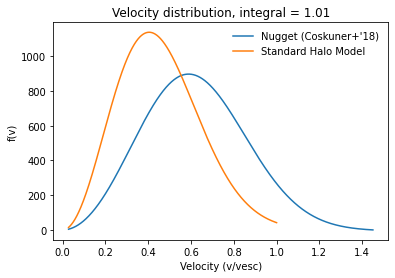

In [8]:
# Plot the DM velocity distribution
nvels = 2000
vels = np.linspace(vmin, vesc + ve, nvels)
vels_shm = np.linspace(vmin, vesc, nvels)

plt.figure()
plt.plot(vels/vesc, f_halo(vels), label='Nugget (Coskuner+\'18)')
plt.plot(vels_shm/vesc, f_halo_dan(vels_shm), label='Standard Halo Model')

plt.title(f'Velocity distribution, integral = {np.trapz(f_halo_dan(vels), vels):.2f}')
plt.legend(frameon=False)
plt.xlabel('Velocity (v/vesc)')
plt.ylabel('f(v)')
plt.show()

## DM scattering rate

The scattering cross section for point-like Yukawa potential $V(r) = (\alpha/r) e^{- m_\phi r}$ is given by (in the Born approximation)

$$
\begin{equation}
\begin{aligned}
    \frac{d\sigma}{d \Omega} 
    &= \frac{ 4 m^2 \alpha^2}{ (m^2_\phi + q^2)^2 }, \\
    &= \frac{4 m^2 \alpha^2}{ (m^2_\phi + 4 p^2 \sin^2 \theta /2 )^2}.
\end{aligned}
\end{equation}
$$

For the massless mediator case this is the exact Rutherford cross section. In this analysis we will cut off events with momentum transfer below the detection threshold and events happen inside the sphere, which deliver momentum transfers above some maximum value.

In [9]:
def dsig_domega_born(mx, mphi, alpha, q, point_charge):
    point_charge_sol = (4 * (mx**2) * (alpha**2) ) / ( (mphi**2 + q**2)**2 )
    if point_charge:
        return point_charge_sol
    else:
        form_factor = 3 * spherical_jn(n=1, z=q*R) / (q * R)
        return point_charge_sol * form_factor**2

In [10]:
q = np.logspace(5, 10, 1000)
dsigdomega = dsig_domega_born(M_X, m_phi, alpha, q, point_charge=True)

Text(0, 0.5, '$d \\sigma / d \\Omega$')

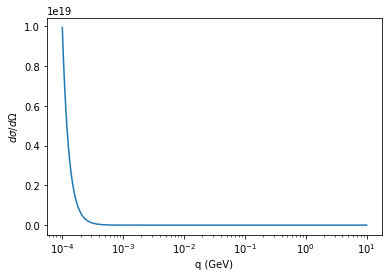

In [11]:
# Expect Rutherford cross section ~ 1 / (q^4)
plt.plot(q/1e9, dsigdomega)
plt.xscale('log')
plt.xlabel('q (GeV)')
plt.ylabel('$d \sigma / d \Omega$')

Integrate over phase space for event rate $dR /dq$.

Convert to $d\sigma / dq$ by 
\begin{equation}
    \frac{d \sigma}{d q} = \frac{2 \pi q}{p^2} \frac{d \sigma}{d \Omega}.
\end{equation}

In [12]:
def dsig_dq(dsigdomega, mx, alpha, q, vlist, q_thr):

    ss = np.empty(shape=(vlist.size, q.size))

    for i, v in enumerate(vlist):
        p = mx * v
        dsigdq = ( 2 * np.pi * q / (p**2) ) * dsigdomega

        # Cut off contribution below detection threshold
        dsigdq[q < q_thr] = 0

        Ecm = 0.5 * mx * v**2

        # Events outside of sphere only
        bmin = 5e-4 / hbarc # 5 um radius
        qmax = 2 * mx * v / np.sqrt(4 * Ecm**2 * bmin**2 / alpha**2 + 1)
        dsigdq[q > qmax] = 0

        # Account for vmin at a given q
        dsigdq[q > 2 * mx * v] = 0
        
        ss[i] = dsigdq
        
    return ss

In [14]:
nvels = 2000
vlist = np.linspace(vmin, vesc, nvels)

dsdq = dsig_dq(dsigdomega, M_X, alpha, q, vlist, q_thr)

int_vec = rhoDM / M_X * vlist * f_halo(vlist)

drdq = np.empty_like(q)
for i in range(q.size):
    drdq[i] = np.trapz( int_vec * dsdq.T[i], x=vlist )

Text(0, 0.5, 'dR/dq (counts / hr / GeV)')

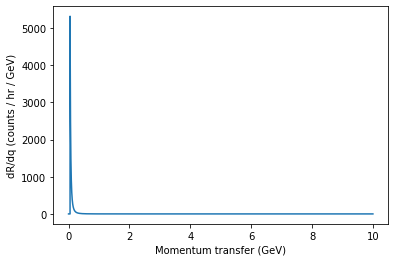

In [15]:
conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr

plt.plot(q/1e9, drdq * conv_fac)
plt.xlabel('Momentum transfer (GeV)')
plt.ylabel('dR/dq (counts / hr / GeV)')

Now generalize to arbitrary DM mass and coupling.

In [16]:
def dR_dq(mx, mphi, alpha, q, vlist, q_thr):
    # Differential cross section
    dsigdomega = dsig_domega_born(mx, mphi, alpha, q, point_charge=True)
    dsigdq = dsig_dq(dsigdomega, mx, alpha, q, vlist, q_thr)
        
    int_vec = rhoDM / mx * vlist * f_halo_dan(vlist)
    
    drdq = np.empty_like(q)
    for i in range(q.size):
        drdq[i] = np.trapz( int_vec * dsigdq.T[i], x=vlist )
        
    conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr
    
    # Counts/hour/GeV
    return drdq * conv_fac

In [17]:
q = np.logspace(5, 10, 1000) # eV

nvels = 2000
vlist = np.linspace(vmin, vesc, nvels)

Total number of events: 0.000


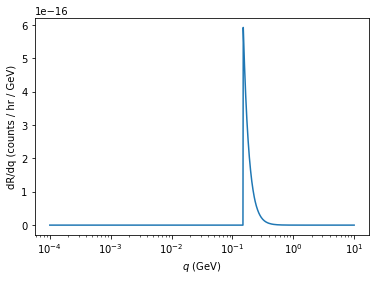

In [19]:
q_thr = 0.15e9
drdq = dR_dq(1e12*1e9, 0, 0.01*alpha/(4*np.pi), q, vlist, q_thr)

drdq = dR_dq(1e21, 0, 100, q, vlist, q_thr)


plt.plot(q/1e9, drdq)
plt.xscale('log')
plt.xlabel('$q$ (GeV)')
plt.ylabel('dR/dq (counts / hr / GeV)')

print( f'Total number of events: {np.trapz(drdq, q/1e9):.3f}' )